In [1]:
import torch
from torch import distributions as torch_D
from torch.distributions import constraints
from matplotlib import pyplot as plt
from matplotlib import cm

import pyro
from pyro import distributions as pyro_D

import time

In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)

from LogitNormal import *

## Logit normal distribution

The pdf of the (scaled) logit normal distribution with location $\mu$, scale $\sigma$, and scaling bounds $a$ and $b$, for $x \in (a, b)$ is:
$$
p(x; \mu, \sigma, a, b) = \phi \left( \text{logit}\left(\frac{x-a}{b-a}\right); \mu, \sigma^2 \right)
    \frac{b-a}{(x-a)(b-x)}
$$

where $\phi(\cdot; \mu, \sigma^2)$ is the pdf of the normal distribution with mean $\mu$ and variance $\sigma^2$.

The location parameter $\mu$ and the scale parameter $\sigma$ are the mean and standard deviation of the parent normal distribution, **not** those of the resulting logit normal distribution.

## Multivariate logit normal distribution

Given location vector $\mu \in \mathbb{R}^n$, positive definite (parent) covariance matrix $\Sigma \in \mathbb{R}^{n \times n}$, and scaling bounds $a \in \mathbb{R}^n$ and $b \in \mathbb{R}^n$, the $n$-dimensional random vector $x$ is a multivariate logit normal distribution (with independent scaling $x_i \in (a_i, b_i)$ for $i=1, ..., n$) if:

$$p(x; \mu, \Sigma, a, b) = \Phi(\tilde{x}; \mu, \Sigma) \prod_i \frac{b_i-a_i}{(x_i-a_i)(b_i-x_i)}$$

where $\tilde{x} = \left[ \text{logit}\left(\frac{x_1-a_1}{b_1-a_1}\right), ..., \text{logit}\left(\frac{x_n-a_n}{b_n-a_n}\right) \right]$ and $\Phi(\cdot; \mu, \Sigma)$ is the pdf of the multivariate normal distribution with mean vector $\mu$ and covariance matrix $\Sigma$.

With reparameterized sampling `rsample` from the multivariate normal distribution already implemented in PyTorch, all we have to do is:
- $x' \sim$ `MultivariateNormal.rsample` $(\mu, \Sigma)$
- $x_i = (b_i-a_i)\text{sigmoid}(x_i') + a_i$

Is the marginal distribution of $x_i$ a logit normal distribution with location $\mu_i$ and scale $\sqrt{\Sigma_{ii}}$?
$$
p(x_i; \mu, \Sigma, a, b) = \phi \left( \text{logit}\left(\frac{x_i-a_i}{b_i-a_i}\right); \mu_i, \Sigma_{ii} \right)
    \frac{b_i-a_i}{(x_i-a_i)(b_i-x_i)}
$$
We will verify this using simple Monte Carlo sampling.

## Toy model

Let $x \sim \text{MultivariateNormal}(\mu_x, \Sigma_x)$. Given fixed $x, \mu_\theta, \Sigma_\theta, a, b$, the generative process of our toy model is:
- $\theta \sim \text{MultivariateLogitNormal}(\mu_\theta, \Sigma_\theta, a, b)$
- $y_i \sim \text{Bernoulli}(\sigma(\theta^T x_i + \theta_0)), i = 1, ..., N$

where $\sigma(\cdot)$ denotes the sigmoid function.

Let $\phi=(\hat{\mu}, \hat{L})$ be the variational parameter. We infer approximate posterior $q_\phi(\theta)=\text{MultivariateLogitNormal}(\hat{\mu}, \hat{L}\hat{L}^T, a, b)$ by finding $\phi$ that minimizes our loss:
$$
\mathcal{L} = E_{q_\phi(\theta)}\left[\log p(\theta) + \log p(y|\theta) - \log q(\theta)\right]
$$

Gradient wrt variational parameter $\phi$:
$$
\nabla_\phi \mathcal{L} \approx -\frac{1}{S} \sum_s \nabla_\phi \left[
    \log p(g_\phi(\epsilon^{(s)})) + \log p(y|g_\phi(\epsilon^{(s)})) - \log q(g_\phi(\epsilon^{(s)}))
    \right]
$$

where $\epsilon^{(s)} \sim \text{MultivariateNormal}(0, I)$ and $g_\phi(\epsilon)=(b-a) \odot \sigma(\hat{\mu}+\hat{L}\epsilon)+a$, with $\odot$ to denote elementwise multiplication.

**Implementation note:** The covariance matrix $\Sigma$ of the multivariate normal in PyTorch is parameterized in terms of a lower-triangular matrix $L$ with positive-valued diagonal entries, such that $\Sigma = LL^T$. In practice, we optimize the unconstrained transformation of $L$. The following code shows how the mapping is done back and forth:
```
def to_constrained(self, x):
    # Takes unconstrained square matrix x and returns L, s.t. Sigma = LL^T
    return x.tril(-1) + x.diagonal(dim1=-2, dim2=-1).exp().diag_embed()

def to_unconstrained(self, y):
    return y.tril(-1) + y.diagonal(dim1=-2, dim2=-1).log().diag_embed()
```

Pseudocode:
- for each iteration $n=1, ..., N$:
  - for each sample $s=1, ..., S$: $\theta^{(s)} \sim q(\theta)$
  - `loss` $= -\frac{1}{S} \sum_s \left[\log p(\theta^{(s)}) + \log p(y|\theta^{(s)}) - \log q(\theta^{(s)})\right]$ 
  - `loss.backward()`

### Generate data
As a first trial, let's consider $D=3, N = 20$ and independent priors.

In [3]:
def generate_data(N, mu_x, sigma_x, mu_theta, sigma_theta, a_theta, b_theta):
    torch.manual_seed(0)
    
    # Sample x
    x_dist = torch_D.multivariate_normal.MultivariateNormal(mu_x, sigma_x)
    x = x_dist.sample((N, )) # (N, D)
    
    # Concat with 1 for bias term
    x_cat = torch.cat((torch.ones((N, 1)), x), 1) # (N, D+1)
    
    # Sample theta
    theta_dist = MultivariateLogitNormal(mu_theta, sigma_theta, a=a_theta, b=b_theta)
    theta = theta_dist.sample() # (D+1, ) including bias term
    
    # Sample y
    p = torch.sigmoid(x_cat @ theta)
    y_dist = torch_D.bernoulli.Bernoulli(p)
    y = y_dist.sample() # (N, )
    
    return x_cat, y, theta_dist, theta

In [4]:
N, D = 50, 3
mu_x = torch.tensor([0., -5., 10.])
sigma_x = torch.eye(D)
mu_theta = torch.tensor([-2., 0., -0.2, 1.]) # (bias, theta1, theta2, theta3)
sigma_theta = torch.diag(torch.tensor([1, 1, 0.2, 1]))
a_theta = torch.tensor([-10, 0, -10, -10])
b_theta = torch.tensor([10, 100, 20, 10])

x, y, p_theta, theta = generate_data(N, mu_x, sigma_x, mu_theta, sigma_theta, a_theta, b_theta)
y, y.mean()

(tensor([0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]),
 tensor(0.8000))

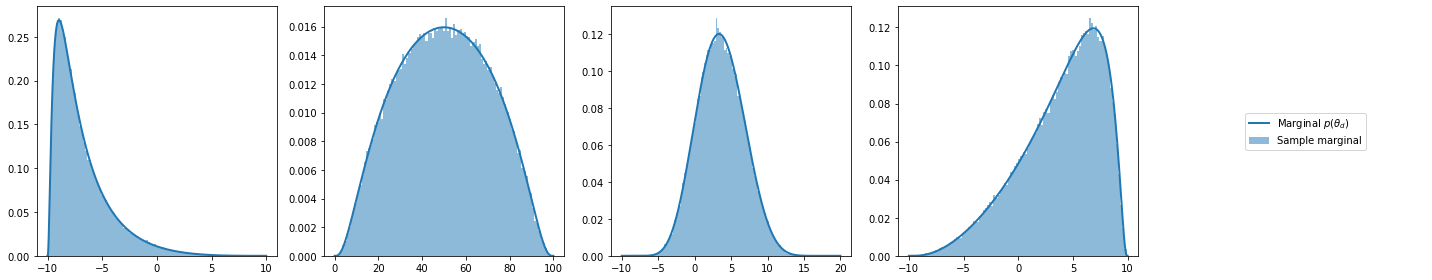

In [5]:
def verify_marginal(p_theta, num_pts=100000, num_samples=100000, bins=100, eps=1e-5):
    a, b = p_theta.a, p_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
    
    # Compute analytical marginal pdf
    scale = torch.diag(p_theta.covariance_matrix).sqrt()
    marg_dist = RescaledLogitNormal(p_theta.loc, scale, a=a, b=b)
    marg_probs = torch.exp(marg_dist.log_prob(theta_range)).detach()
    approx_int = marg_probs.sum(0) * (b - a) / num_pts
    assert torch.all(torch.isclose(torch.ones([]), approx_int))
    
    # Plot analytical vs empirical marginals
    D = len(p_theta.loc)
    fig, axes = plt.subplots(1, D+1, figsize=(4*(D+1), 4))
    
    assert isinstance(p_theta, MultivariateLogitNormal)
    samples = p_theta.sample((num_samples, ))
    for i, ax in enumerate(axes):
        if i < D:
            ax.hist(np.array(samples[:, i]), bins=bins, density=True, label='Sample marginal', color='tab:blue', alpha=0.5)
            ax.plot(theta_range[:, i], marg_probs[:, i], label='Marginal $p(\\theta_d)$', color='tab:blue', linewidth=2)
        else:
            handles, labels = axes[0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center')
            ax.axis('off')
            
    plt.tight_layout()
            
verify_marginal(p_theta)

### Inference

In [6]:
class VariationalPosterior(nn.Module):
    def __init__(self, init_loc, init_scale, lower_bounds, upper_bounds, mean_field=False):
        super().__init__()
        if mean_field:
            self.dist = RescaledLogitNormal
            scale_constraint = self.dist.arg_constraints['scale']
            unconstrained_scale = torch_D.transform_to(scale_constraint).inv(torch.diag(1.0 * init_scale))
            #unconstrained_scale = 1.0 * torch.diag(init_scale)
            #print(unconstrained_scale)
        else:
            self.dist = MultivariateLogitNormal
            scale_constraint = self.dist.arg_constraints['scale_tril']
            unconstrained_scale = torch_D.transform_to(scale_constraint).inv(1.0 * init_scale)
            
        self.loc = nn.Parameter(1.0 * init_loc) # (D, )
        self.unconstrained_scale = nn.Parameter(unconstrained_scale) # (D, ) if mean_field else (D, D)
        self.lower = lower_bounds
        self.upper = upper_bounds
        self.mean_field = mean_field

    def forward(self, N=10):
        # Update posterior
        parent_loc = self.loc        
        if self.mean_field:
            parent_scale = torch_D.transform_to(self.dist.arg_constraints['scale'])(self.unconstrained_scale)
            #print(parent_scale)
            q_dist = self.dist(parent_loc, scale=parent_scale, a = self.lower, b = self.upper)
        else:
            parent_scale = torch_D.transform_to(self.dist.arg_constraints['scale_tril'])(self.unconstrained_scale)
            q_dist = self.dist(parent_loc, scale_tril=parent_scale, a = self.lower, b = self.upper)

        # Sample theta ~ q(theta).
        samples = q_dist.rsample((N, )) # (N, num_params)
        #print(samples)
        
        # Evaluate log prob of theta samples.
        if self.mean_field:
            log_q_theta = torch.sum(q_dist.log_prob(samples), -1) # (N, )
            #print('log_post', log_q_theta, q_dist.log_prob(samples))
        else:
            log_q_theta = q_dist.log_prob(samples) # (N, )
            #print('log_post', log_q_theta)
        
        return samples, log_q_theta

In [7]:
def train(x, y, p_theta, lr, num_iters, batch_size=10, print_every=10, mean_field=False):
    torch.manual_seed(0)
    
    # Initialize variational parameters with prior parameter values
    q_theta = VariationalPosterior(p_theta.loc, p_theta.scale_tril, p_theta.a, p_theta.b, mean_field=mean_field)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(q_theta.parameters(), lr=lr)
    #optimizer = torch.optim.Adagrad(q_theta.parameters(), lr=lr)
    
    # Initialize lists to record loss and time hist
    t0 = time.time()
    loss_hist = []
    time_hist = [0]
    
    # Do inference
    N, D = x.shape
    for i in range(num_iters + 1):
        optimizer.zero_grad()
        
        # Sample theta and compute log q(theta)
        theta, log_post = q_theta(batch_size)
        assert theta.shape == (batch_size, D)
        assert log_post.shape == (batch_size, )
        
        # Compute log p(theta)
        log_prior = p_theta.log_prob(theta) # (batch_size, )
        #print('log_prior', log_prior)
        #print('test prior', p_theta.log_prob(torch.tensor([-2.2556, 42.7165, -2.9181,  6.5512])))
        assert log_prior.shape == (batch_size, )
        
        # Compute log p(y|theta; x)
        p_y = torch_D.bernoulli.Bernoulli(torch.sigmoid(theta @ x.T)) # p_y.probs.shape == (batch_size, N)
        log_lik = p_y.log_prob(y.reshape((1, -1))).sum(-1) # (batch_size, N) -> (batch_size, )
        #print(log_lik)
        assert log_lik.shape == (batch_size, )
        
        # Compute (and record) negative ELBO: -(log p(theta) + log p(y|theta; x) - log q(theta)).mean()
        loss = -log_prior.mean() - log_lik.mean() + log_post.mean()
        loss_hist.append(loss)
        if i%print_every == 0:
            print('Iteration {} loss: {}'.format(i, loss))
        
        # Last iteration only computes final loss, but does not make another gradient step
        if i < num_iters:
            # Take a gradient step
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(q_theta.parameters(), 3.0)
            optimizer.step()
            
            # Record time
            time_hist.append(time.time() - t0)
        
    assert len(loss_hist) == len(time_hist) == (num_iters + 1)
    return q_theta, loss_hist, time_hist

In [8]:
q_theta_raw, loss_hist, time_hist = train(x, y, p_theta, 0.05, 500, batch_size=100, print_every=50)

Iteration 0 loss: 164.5594482421875
Iteration 50 loss: 21.754741668701172
Iteration 100 loss: 14.208433151245117
Iteration 150 loss: 12.450258255004883
Iteration 200 loss: 11.820634841918945
Iteration 250 loss: 10.945945739746094
Iteration 300 loss: 10.687045097351074
Iteration 350 loss: 10.338996887207031
Iteration 400 loss: 10.005005836486816
Iteration 450 loss: 9.30113410949707
Iteration 500 loss: 9.420284271240234


In [9]:
q_theta_raw_mf, loss_hist_mf, time_hist_mf = train(x, y, p_theta, 0.05, 500, batch_size=100, print_every=50, mean_field=True)

Iteration 0 loss: 164.5594482421875
Iteration 50 loss: 23.42164421081543
Iteration 100 loss: 17.166706085205078
Iteration 150 loss: 15.591561317443848
Iteration 200 loss: 14.56497573852539
Iteration 250 loss: 14.360965728759766
Iteration 300 loss: 13.743667602539062
Iteration 350 loss: 12.913688659667969
Iteration 400 loss: 13.208775520324707
Iteration 450 loss: 13.324016571044922
Iteration 500 loss: 12.751117706298828


In [10]:
# Extracts the distribution from a MeanField object
def extract_dist(q):
    a, b = q.lower, q.upper
    loc = q.loc
    if q.mean_field:
        scale = torch_D.transform_to(q.dist.arg_constraints['scale'])(q.unconstrained_scale)
        return q.dist(loc, scale=scale, a=a, b=b)
    else:
        scale = torch_D.transform_to(q.dist.arg_constraints['scale_tril'])(q.unconstrained_scale)
        return q.dist(loc, scale_tril=scale, a=a, b=b)

q_theta = extract_dist(q_theta_raw)
q_theta_mf = extract_dist(q_theta_raw_mf)

In [ ]:
p_theta.covariance_matrix.sqrt()

In [ ]:
theta = torch.tensor([[-2.2556, 42.7165, -2.9181,  6.5512], [-9.1250, 19.8039,  4.8529,  7.2543]])
p_theta.log_prob(theta)

In [ ]:
p_theta.sample((10, 5, 6 )).shape

In [ ]:
p_theta_factor = RescaledLogitNormal(loc=p_theta.loc, scale=torch.diag(p_theta.scale_tril), a=p_theta.a, b=p_theta.b)

In [ ]:
p_theta_factor.log_prob(theta).sum()

### Pyro black-box VI comparison

We can rewrite the generative process of the toy model as:
- $\hat{\theta} \sim \text{MultivariateNormal}(\mu_\theta, \Sigma_\theta)$
- $\theta_d = (b_d-a_d) \sigma(\hat{\theta}_d)+a_d, d=1, ..., D$
- $y_i \sim \text{Bernoulli}(\sigma(\theta^Tx_i + \theta_0)), i = 1, ..., N$

with fixed $x, \mu_\theta, \Sigma_\theta, a, b$.

In [ ]:
def model(x, y, mu_theta, sigma_theta, a, b, mean_field=False):
    N, D = x.shape
    if mean_field:
        theta_axis = pyro.plate('theta_axis', D)
        with theta_axis:
            theta_hat = pyro.sample('theta_hat', pyro_D.Normal(mu_theta, scale=torch.diag(sigma_theta)))
    else:
        theta_hat = pyro.sample('theta_hat', pyro_D.MultivariateNormal(mu_theta, scale_tril=sigma_theta))
    #print(theta_hat.shape)
    theta = (b - a)*torch.sigmoid(theta_hat) + a
        
    data_axis = pyro.plate('data_axis', N)
    with data_axis:
        p_y = torch.sigmoid(theta @ x.T)
        y = pyro.sample('labels', pyro_D.Bernoulli(probs=p_y), obs=y)

In [ ]:
def guide(x, y, mu_theta, sigma_theta, a, b, mean_field=False):
    N, D = x.shape
    mu_post = pyro.param('mu_post')
    sigma_post = pyro.param('sigma_post') # scale if mean_field, scale_tril o/w
        
    if mean_field:
        theta_axis = pyro.plate('theta_axis', D)
        with theta_axis:
            theta_hat = pyro.sample('theta_hat', pyro_D.Normal(mu_post, scale=sigma_post))
    else:
        pyro.sample('theta_hat', pyro_D.MultivariateNormal(mu_post, scale_tril=sigma_post))

In [ ]:
def init_params(init_mu, init_scale, mean_field=False):
    pyro.clear_param_store()
    pyro.param('mu_post', 1.0 * init_mu)
    scale_constraint = constraints.positive if mean_field else constraints.lower_cholesky
    init_scale = torch.diag(init_scale) if mean_field else init_scale
    pyro.param('sigma_post', 1.0 * init_scale, constraint=scale_constraint)

In [ ]:
def train_pyro(x, y, p_theta, lr, num_iters, batch_size=10, print_every=10, mean_field=False):
    torch.manual_seed(0)
    
    # Initialize variational parameters with prior parameter values
    mu_theta, sigma_theta, a, b = p_theta.loc, p_theta.scale_tril, p_theta.a, p_theta.b
    init_params(mu_theta, sigma_theta, mean_field=mean_field)
    
    # Initialize loss and optimizer
    loss = pyro.infer.TraceGraph_ELBO(num_particles=batch_size)
    optimizer = pyro.optim.Adam({'lr': lr})
    #optimizer = pyro.optim.Adagrad({'lr': lr})
    
    # Initialize SVI
    svi = pyro.infer.SVI(model=model,
                         guide=guide,
                         optim=optimizer,
                         loss=loss)
    
    # Initialize lists to record loss and time hist
    loss0 = svi.evaluate_loss(x, y, mu_theta, sigma_theta, a, b, mean_field=mean_field)
    t0 = time.time()
    loss_hist = [loss0]
    time_hist = [0]
    
    # Do inference
    N, D = x.shape
    for i in range(num_iters):
        # Take a gradient step
        loss = svi.step(x, y, mu_theta, sigma_theta, a, b, mean_field=mean_field)
        
        # Record loss and time
        loss_hist.append(loss)
        time_hist.append(time.time() - t0)
        if i%print_every == 0:
            print('Iteration {} loss: {}'.format(i, loss))
        
    assert len(loss_hist) == len(time_hist) == (num_iters + 1)
    return loss_hist, time_hist

def extract_dist_pyro(p_theta, mean_field=False):
    a, b = p_theta.a, p_theta.b
    loc = pyro.param('mu_post')
    scale = pyro.param('sigma_post')
    if mean_field:
        return RescaledLogitNormal(loc, scale=scale, a=a, b=b)
    else:
        return MultivariateLogitNormal(loc, scale_tril=scale, a=a, b=b)

In [ ]:
loss_hist_pyro, time_hist_pyro = train_pyro(x, y, p_theta, 0.05, 500, batch_size=100, print_every=50)
q_theta_pyro = extract_dist_pyro(p_theta)

In [ ]:
loss_hist_pyro_mf, time_hist_pyro_mf = train_pyro(x, y, p_theta, 0.05, 500, batch_size=100, print_every=50, mean_field=True)
q_theta_pyro_mf = extract_dist_pyro(p_theta, mean_field=True)

### Visualizations

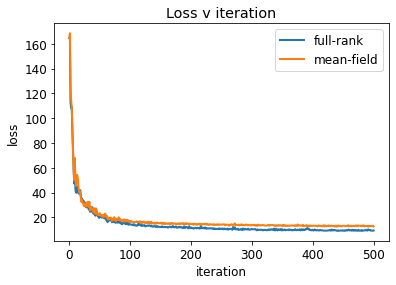

In [11]:
def plot_loss(loss_hist_list, labels, time_hist_list=None, xscale='linear'):
    if time_hist_list is None:
        time_hist_list = [None] * len(loss_hist_list)
        
    plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2})
    for loss_hist, label, time_hist in zip(loss_hist_list, labels, time_hist_list):
        if time_hist:
            plt.plot(time_hist, loss_hist, label=label)
        else:
            plt.plot(loss_hist, label=label)
    
    if time_hist_list[0]:
        plt.xlabel('time')
        plt.title('Loss v time')
    else:
        plt.xlabel('iteration')
        plt.title('Loss v iteration')
    plt.ylabel('loss')
    plt.legend()
    plt.xscale(xscale)
    
labels = ['full-rank', 'mean-field']
plot_loss([loss_hist, loss_hist_mf], labels)

In [ ]:
labels = ['custom full-rank', 'custom mean-field', 'pyro full-rank', 'pyro mean-field']
plot_loss([loss_hist, loss_hist_mf, loss_hist_pyro, loss_hist_pyro_mf], labels)

In [ ]:
plot_loss([loss_hist, loss_hist_mf, loss_hist_pyro, loss_hist_pyro_mf], labels,
          [time_hist, time_hist_mf, time_hist_pyro, time_hist_pyro_mf], xscale='symlog')

In [ ]:
def plot_theta(p_theta, q_theta_list, labels, num_pts=100000, eps=1e-5):
    a, b = p_theta.a, p_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
    
    # Prior
    scale_prior = torch.diag(p_theta.covariance_matrix).sqrt()
    marg_prior_dist = RescaledLogitNormal(p_theta.loc, scale_prior, a=a, b=b)
    marg_prior = torch.exp(marg_prior_dist.log_prob(theta_range)).detach()
    approx_int_prior = marg_prior.sum(0) * (b - a) / num_pts
    assert torch.all(torch.isclose(torch.ones([]), approx_int_prior))
    
    # Posterior
    marg_post_list = []
    for q_theta in q_theta_list:
        if isinstance(q_theta, RescaledLogitNormal):
            marg_post_dist = q_theta
        else:
            scale_post = torch.diag(q_theta.covariance_matrix).sqrt()
            marg_post_dist = RescaledLogitNormal(q_theta.loc, scale_post, a=a, b=b)
        marg_post = torch.exp(marg_post_dist.log_prob(theta_range)).detach()
        approx_int_post = marg_post.sum(0) * (b - a) / num_pts
        assert torch.all(torch.isclose(torch.ones([]), approx_int_post))
        marg_post_list.append(marg_post)
    
    # Plot prior & posterior vs true theta
    D = len(p_theta.loc)
    plt.rcParams.update({'font.size': 16, 'lines.linewidth': 2})
    fig, axes = plt.subplots(1, D+1, figsize=(4*(D+1), 4))
    xlabels = ['bias', '$\\theta_1$', '$\\theta_2$', '$\\theta_3$']
    for i, ax in enumerate(axes):
        #print(i, D)
        if i < D:
            ax.plot(theta_range[:, i], marg_prior[:, i], label='prior $p(\\theta)$', color='tab:blue', linewidth=2)
            for j, (marg_post, alg) in enumerate(zip(marg_post_list, labels)):
                label = '{} posterior $q(\\theta)$'.format(alg)
                ax.plot(theta_range[:, i], marg_post[:, i], label=label, color=cm.tab10(j+1), linewidth=2)
            ax.axvline(theta[i], color='gray', label='true $\\theta$')
            ax.set_xlabel(xlabels[i])
            if i == 0: ax.set_ylabel('density')
        else:
            handles, labels = axes[0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center')
            ax.axis('off')
    
    plt.tight_layout()
    plt.suptitle('Marginal distributions')
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_theta(p_theta, [q_theta, q_theta_mf, q_theta_pyro, q_theta_pyro_mf], labels)

In [ ]:
q_theta_pyro_mf.b

In [ ]:
q_theta_pyro.b

In [ ]:
def plot_corr(q_theta_list, labels, num_samples=100000):
    # Calculate empirical correlation
    corr_list = []
    for q_theta in q_theta_list:
        assert isinstance(q_theta, MultivariateLogitNormal)
        samples = q_theta.sample((num_samples, )) # (N, D)
        corr_mc = np.corrcoef(samples.T)
        corr_list.append(corr_mc)
    
    # Plot
    num_cols = len(q_theta_list)
    plt.rcParams.update({'font.size': 12})
    fig, axes = plt.subplots(1, num_cols, figsize=(5*num_cols, 5))
    ax_labels = ['bias', '$\\theta_1$', '$\\theta_2$', '$\\theta_3$']
    D = len(q_theta_list[0].loc)
    
    for i, ax in enumerate(axes):
        plot = ax.imshow(corr_list[i], cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_xticks(range(D))
        ax.set_xticklabels(ax_labels)
        ax.set_yticks(range(D))
        ax.set_yticklabels(ax_labels)
        ax.set_title(labels[i])
        
    plt.tight_layout()
    plt.colorbar(plot, ax=axes, shrink=0.8)
    plt.suptitle('Correlation between $\\theta_d$')
    plt.show()
    
plot_corr([q_theta, q_theta_pyro], [labels[0], labels[2]])

### Notes on `scale_tril` constraint

In [ ]:
scale_tril = torch.diag(torch.arange(1, 5))
scale_tril

In [ ]:
constraint = torch_D.multivariate_normal.MultivariateNormal.arg_constraints['scale_tril']

In [ ]:
unconstrained_scale_tril = torch_D.transform_to(constraint).inv(scale_tril)

In [ ]:
scale_tril = torch_D.transform_to(constraint)(unconstrained_scale_tril)
scale_tril

Without this inverse transformation at initialization, the constrained values of `scale_tril` used at the first inference iteration would be **incorrect** (i.e. initialization won't actually match prior/whatever we think we init it with):

In [ ]:
torch_D.transform_to(constraint)(scale_tril)

In [ ]:
from TruncatedNormal import *

In [ ]:
rv = TruncatedNormal(-2, 2, a=0, b=10)
samples = rv.sample((10,))
log_probs = rv.log_prob(samples)
samples, log_probs

In [ ]:
num_pts = 1000
pts = torch.linspace(0, 10, num_pts)
pdf = torch.exp(rv.log_prob(pts))
plt.plot(pts, pdf)

In [ ]:

loc, scale = -100, 0.00001
a = (a - loc) / scale
b = (b - loc) / scale
a < b

In [ ]:
cm.tab10(1)

In [ ]:
torch.diag_embed(torch.ones(5))

In [ ]:
x = -1 * torch.arange(16).reshape((4, 4))
x

In [ ]:
scale_tril = x.tril(-1) + x.diagonal(dim1=-2, dim2=-1).exp().diag_embed()
scale_tril

In [ ]:
scale_tril.T

In [ ]:
scale_tril @ scale_tril.T

In [ ]:
p_theta.scale_tril

In [ ]:
p_theta.covariance_matrix.sqrt()